In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input , Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import cv2 as cv
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

In [21]:
test_data = 'english.csv'
df = pd.read_csv(test_data)

In [22]:
df["label"].value_counts()

label
0    55
k    55
X    55
Y    55
Z    55
     ..
P    55
Q    55
R    55
S    55
z    55
Name: count, Length: 62, dtype: int64

In [24]:
df['image'] = df['image'].str.strip().str.replace('\\', '/')  # Normalize paths

In [25]:
images_path = 'Img'

# List to hold the dimensions of all images
image_sizes = []

for image_file in os.listdir(images_path):
    image_path = os.path.join(images_path, image_file)
    image = cv.imread(image_path)
    if image is not None:
        height, width = image.shape[:2]
        image_sizes.append((width, height))

# Print the size of the first image
if image_sizes:
    print("Size of the first image:", image_sizes[1])
    print("Unique image sizes:", set(image_sizes))
else:
    print("No images found in the directory.")

Size of the first image: (1200, 900)
Unique image sizes: {(1200, 900)}


In [26]:
images_path = 'Img'
images = []
labels = []

for image_file in os.listdir(images_path):
    image_path = os.path.join(images_path, image_file).replace('\\', '/')  # Normalize
    image = cv.imread(image_path, cv.IMREAD_GRAYSCALE).astype('float32')
    image = cv.resize(image, (64, 64)) / 255.0  # Resize and normalize

    # Fetch label from CSV
    try:
        label = df[df['image'] == image_path].label.values[0]
        images.append(image)
        labels.append(label)
    except IndexError:
        print(f"No label found for {image_file}")

images = np.array(images)
labels = np.array(labels)

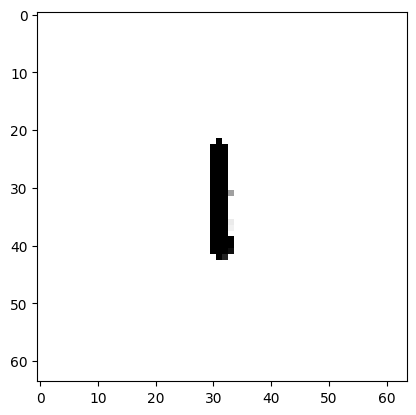

In [27]:
plt.gray()
plt.imshow(images[100])

In [28]:
print("Number of images:", len(images))
print("Shape of each image:", images.shape[1:])
print("Unique labels:", np.unique(labels))

Number of images: 3410
Shape of each image: (64, 64)
Unique labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [29]:
# One hot encode the labels

encoder = OneHotEncoder(sparse_output=False)
labels = encoder.fit_transform(labels.reshape(-1, 1))

In [30]:
decoder = [str(i) for i in range(10)] + [chr(i) for i in range(65, 91)] + [chr(i) for i in range(97, 123)]

In [31]:
images, labels = shuffle(images, labels, random_state=0)

In [32]:
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

# Define an exponential decay learning rate schedule function
def exponential_decay(epoch, lr):
    initial_lr = 0.001
    k = 0.1
    decay_rate = k ** (epoch / 10)
    return initial_lr * decay_rate

In [33]:
X_train, X_temp, Y_train, Y_temp = train_test_split(images, labels, test_size=0.3, random_state=0)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=0)

In [34]:
datagen = ImageDataGenerator(
    rotation_range=15,    
    width_shift_range=0.1,  
    height_shift_range=0.2,
    zoom_range=0.2, 
    shear_range=0.2,               
    fill_mode='nearest'
)

In [35]:
# Initialize lists to hold augmented images and labels
augmented_arr_X = []
augmented_arr_Y = []
number_of_augmentation = 5

# Iterate over each image in X_train
for i in range(len(X_train)):
    # Ensure the image has the correct shape (height, width, channels)
    image = X_train[i]
    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)  # Convert (height, width) to (height, width, channels)
    
    # Expand dimensions to include batch size
    image_expanded = np.expand_dims(image, axis=0)  # Shape: (1, height, width, channels)
    
    # Create iterator for augmented images
    aug_iter = datagen.flow(image_expanded, batch_size=1)
    
    # Generate augmented images
    augmented_images = [next(aug_iter)[0] for _ in range(number_of_augmentation)]
    
    # Extend the list with the new augmented images and corresponding labels
    augmented_arr_X.extend(augmented_images)
    augmented_arr_Y.extend([Y_train[i]] * number_of_augmentation)

# Convert lists to numpy arrays
augmented_arr_X = np.array(augmented_arr_X)
augmented_arr_Y = np.array(augmented_arr_Y)

print("Augmented images shape:", augmented_arr_X.shape)
print("Augmented labels shape:", augmented_arr_Y.shape)

Augmented images shape: (11935, 64, 64, 1)
Augmented labels shape: (11935, 62)


In [36]:
X_train = np.array(augmented_arr_X)
Y_train = np.array(augmented_arr_Y)

In [37]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=0)

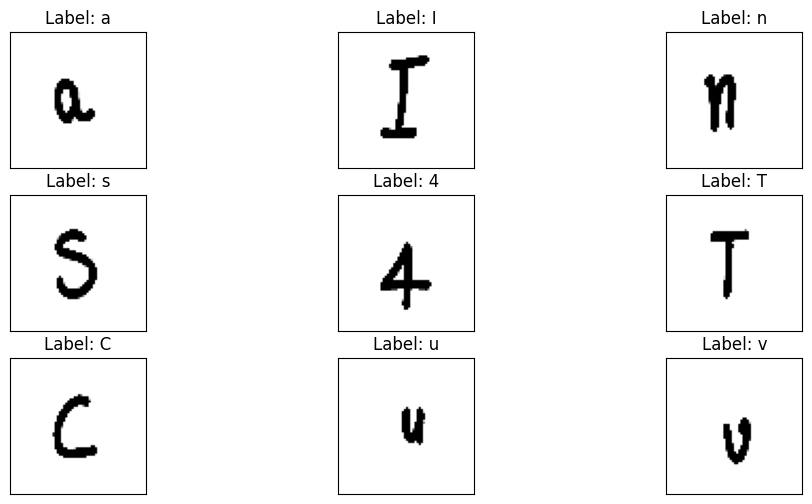

In [38]:
# Plot 9 random images for visualisation

def display_images(rows, cols, images, labels, decoder):
    _, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(12,6))

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Label: {decoder[np.where(labels[i]==1)[0][0]]}")
        
display_images(3, 3, images, labels, decoder)

In [39]:
num_classes = len(np.unique(labels))  # Check how many unique labels you have
print("Number of classes:", num_classes)

Number of classes: 2


In [40]:
# Define model

model = Sequential([
    Input(shape=(64, 64, 1)),
    
    Conv2D(512, (5, 5), activation='relu'),
    
    MaxPooling2D(pool_size=(2, 2)), 
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.1),
    
    Dense(1024, activation='relu'),
    
    Dense(512, activation='relu'),
    Dropout(0.1),
    
    Dense(256, activation='sigmoid'),
    
    Dense(62, activation='softmax')
])

In [41]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 60, 512)    │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 62)             │        15,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,699,774 (29.37 MB)

 Trainable params: 7,699,774 (29.37 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)


Shape of X_train: (11935, 64, 64, 1)
Shape of X_val: (511, 64, 64)
Shape of X_test: (512, 64, 64)


In [43]:
import tensorflow as tf

from tensorflow.keras.mixed_precision import global_policy, set_global_policy, Policy

# Create a mixed precision policy
policy = Policy('mixed_float16')
set_global_policy(policy)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))


lr_scheduler = LearningRateScheduler(scheduler)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),  # Use a lower learning rate for stability
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with the callbacks
history = model.fit(
    X_train, Y_train,
    epochs=20, 
    batch_size=32,  
    validation_data=(X_val, Y_val),
    callbacks=[lr_scheduler, early_stopping]  # Add both callbacks here
)

Epoch 1/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 192s 502ms/step - accuracy: 0.0186 - loss: 4.1743 - val_accuracy: 0.0215 - val_loss: 4.0386 - learning_rate: 1.0000e-04
Epoch 2/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 184s 494ms/step - accuracy: 0.0754 - loss: 3.7344 - val_accuracy: 0.1429 - val_loss: 3.1570 - learning_rate: 1.0000e-04
Epoch 3/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 185s 496ms/step - accuracy: 0.1527 - loss: 3.2140 - val_accuracy: 0.2779 - val_loss: 2.6665 - learning_rate: 1.0000e-04
Epoch 4/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 240s 643ms/step - accuracy: 0.2808 - loss: 2.7039 - val_accuracy: 0.3796 - val_loss: 2.2234 - learning_rate: 1.0000e-04
Epoch 5/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 213s 510ms/step - accuracy: 0.4013 - loss: 2.2608 - val_accuracy: 0.5205 - val_loss: 1.7483 - learning_rate: 1.0000e-04
Epoch 6/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 217s 582ms/step - accuracy: 0.5036 - loss: 1.8783 - val_accuracy: 0.5812 - val_loss: 1.5040 - learning_rate: 1.0000e-04
Epoch 7/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 

In [44]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val, Y_val)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.7995 - loss: 0.6012
Validation Loss: 0.5510808825492859
Validation Accuracy: 0.8003913760185242


In [45]:
import joblib

# Save the label encoder
joblib.dump(encoder, 'label_encoder_2.pkl')

['label_encoder_2.pkl']

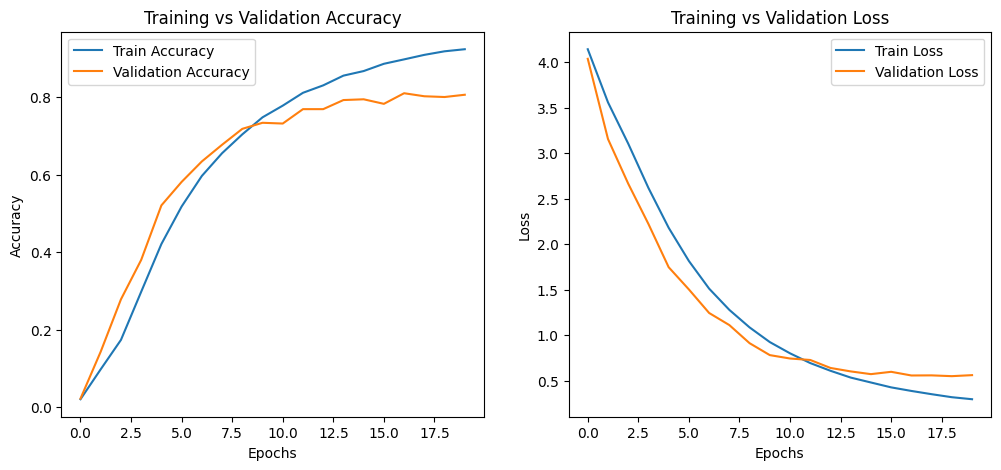

In [46]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()

In [47]:
model.save("recognition_model_2.h5")

In [53]:
# Load the trained model
model = tf.keras.models.load_model('recognition_model_2.h5')

# Load the label encoder
encoder = joblib.load('label_encoder_2.pkl')

def predict_character(image_path):
    # Load and preprocess the image
    image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    image = cv.resize(image, (64, 64)) / 255.0
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = np.expand_dims(image, axis=0)   # Add batch dimension

    # Predict
    prediction = model.predict(image)
    predicted_label = np.argmax(prediction)

    # Decode the label (fix for expected shape)
    one_hot = np.zeros((1, 62))
    one_hot[0, predicted_label] = 1
    label = encoder.inverse_transform(one_hot)[0]

    print(f"Predicted Label: {label}")

# Example usage
image_path = 'Img/img062-051.png'
predict_character(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Predicted Label: ['z']
